In [2]:
import pandas as pd
import numpy as np

## Import Data

In [4]:
handles_real = pd.read_csv('real.csv',header=None,names=['Handle'])

handles_real['Real']=list(np.ones((len(handles_real['Handle'])), dtype=int))

In [6]:
handles_fake = pd.read_csv('fake.csv',header=None,names=['Handle'])

handles_fake['Real']=list(np.zeros((len(handles_fake['Handle'])), dtype=int))

In [8]:
df = [handles_real,handles_fake]
handles = pd.concat(df)

In [14]:
json_df = pd.read_csv('json_df')
json_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17488 entries, 0 to 17487
Data columns (total 32 columns):
biography                                    12993 non-null object
blocked_by_viewer                            17488 non-null bool
connected_fb_page                            0 non-null float64
country_block                                17488 non-null bool
external_url                                 5317 non-null object
external_url_linkshimmed                     5317 non-null object
followed_by.count                            17488 non-null int64
followed_by_viewer                           17488 non-null bool
follows.count                                17488 non-null int64
follows_viewer                               17488 non-null bool
full_name                                    17185 non-null object
has_blocked_viewer                           17488 non-null bool
has_requested_viewer                         17488 non-null bool
id                                     

In [15]:
json_df.drop(['connected_fb_page','external_url_linkshimmed','followed_by_viewer','follows_viewer','has_blocked_viewer','has_requested_viewer','media.page_info.end_cursor','media.page_info.has_next_page','media_collections.count','media_collections.edges','media_collections.page_info.end_cursor','media_collections.page_info.has_next_page','requested_by_viewer','saved_media.count','saved_media.nodes','saved_media.page_info.end_cursor','saved_media.page_info.has_next_page','blocked_by_viewer','country_block'],axis=1, inplace=True)

In [16]:
json_df.describe()

,followed_by.count,follows.count,id,media.count
count,1.748800e+04,17488.000000,1.748800e+04,17488.000000
mean,2.365129e+03,3358.146615,2.595493e+09,285.953625
std,1.914366e+04,3129.167355,2.296924e+09,762.531915
min,0.000000e+00,0.000000,7.380000e+02,0.000000
25%,2.370000e+02,551.750000,3.063246e+08,9.000000
50%,5.370000e+02,1464.000000,1.943691e+09,65.000000
75%,1.161000e+03,7452.000000,4.769349e+09,293.000000
max,1.628148e+06,7521.000000,6.944068e+09,43030.000000


In [17]:
handles['username'] = handles['Handle'].apply(lambda x: x.replace('@',""))

In [18]:
enriched_df = pd.merge(handles,json_df,on='username',how='right')

In [19]:
enriched_df.head()

,Handle,Real,username,biography,external_url,followed_by.count,follows.count,full_name,id,is_private,is_verified,media.count,media.nodes,profile_pic_url,profile_pic_url_hd
0,@iamsarahharris,1,iamsarahharris,🌴Bali 4th - 20th Jan\n🎥 YT: SachiiVlogs \n🔒Jos...,http://youtube.com/sachiivlogs,1628148,251,Sarah Harris,50169916,False,True,464,"[{'__typename': 'GraphImage', 'id': '169519047...",https://scontent-lga3-1.cdninstagram.com/t51.2...,https://scontent-lga3-1.cdninstagram.com/t51.2...
1,@askamillionaire,1,askamillionaire,A Subscription-Based\nMentor Platform For Entr...,http://www.mostwontiwill.com/,1179604,35,"Ask A Millionaire, LLC",1711829639,False,True,269,"[{'__typename': 'GraphImage', 'id': '169581749...",https://scontent-lga3-1.cdninstagram.com/t51.2...,https://scontent-lga3-1.cdninstagram.com/t51.2...
2,@paintedhair,1,paintedhair,"✨PaintedHair™✨Sacramento,CA❤✨Healthy Hair ✨Mas...",NaN,676539,907,Patricia Nikole,43393230,False,False,2623,"[{'__typename': 'GraphVideo', 'id': '169543009...",https://scontent-lga3-1.cdninstagram.com/t51.2...,https://scontent-lga3-1.cdninstagram.com/t51.2...
3,@ianmcrumm,1,ianmcrumm,"Menswear, Grooming, Wellness + Leisure. Catch ...",https://youtu.be/ZJ1o_vOkmc8,379968,1441,Ian Michael Crumm,24623409,False,False,1405,"[{'__typename': 'GraphImage', 'id': '169468414...",https://scontent-lga3-1.cdninstagram.com/t51.2...,https://scontent-lga3-1.cdninstagram.com/t51.2...
4,@igorsebba21,1,igorsebba21,CEO e Fundador @Piatan.Natural 🇧🇷 \nEmpreenden...,http://www.piatan.com.vc/,342461,4035,Igor Sebba - Empreendedorismo,1982670895,False,False,774,"[{'__typename': 'GraphVideo', 'id': '169564452...",https://scontent-lga3-1.cdninstagram.com/t51.2...,https://scontent-lga3-1.cdninstagram.com/t51.2...


In [93]:
enriched_df['Real'].value_counts()

1    9612
0    7876
Name: Real, dtype: int64

## Baseline Model

In [163]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures

In [81]:
bl_features = enriched_df[['followed_by.count','follows.count','is_private','is_verified','media.count']]
bl_target = enriched_df['Real']

In [83]:
def classify_users(classifier, X_train, X_test, y_train, y_test):
    '''
    Train a classifier to identify if user is real or fake 
    
    '''
    #fit the classifier with our training data
    classifier.fit(X_train, y_train)
    
    #predict the labels of our train data and store them in train_preds
    train_preds = classifier.predict(X_train)

    #predict the labels of our test data and store them in test_preds
    test_preds = classifier.predict(X_test)
    
    print('Training accuracy: ', accuracy_score(y_train, train_preds))
    print('Testing accuracy: ', accuracy_score(y_test, test_preds))
    
    print('Testing Report: \n',classification_report(y_test, test_preds))
    
    cm_nb = confusion_matrix(y_test, test_preds)
    plt.figure(figsize = (6, 6))
    plt.title(classifier)
    
    return sns.heatmap(cm_nb, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "YlGnBu"), plt.xlabel('Predicted Label'),plt.ylabel('True Label')


In [85]:
X_train, X_test, y_train, y_test = train_test_split(bl_features, bl_target, test_size=0.2, random_state=42)

In [89]:
mm_scaler = MinMaxScaler()

In [90]:
X_train_scaled = mm_scaler.fit_transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)

/Users/samantha/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype bool, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [91]:
bl_lr = LogisticRegression()

Training accuracy:  0.9118656182987849
Testing accuracy:  0.9070897655803316
Testing Report: 
               precision    recall  f1-score   support

           0       0.93      0.85      0.89      1569
           1       0.89      0.95      0.92      1929

   micro avg       0.91      0.91      0.91      3498
   macro avg       0.91      0.90      0.91      3498
weighted avg       0.91      0.91      0.91      3498



/Users/samantha/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(<matplotlib.axes._subplots.AxesSubplot at 0x11d4621d0>,
 Text(0.5, 62.15999999999998, 'Predicted Label'),
 Text(33.0, 0.5, 'True Label'))

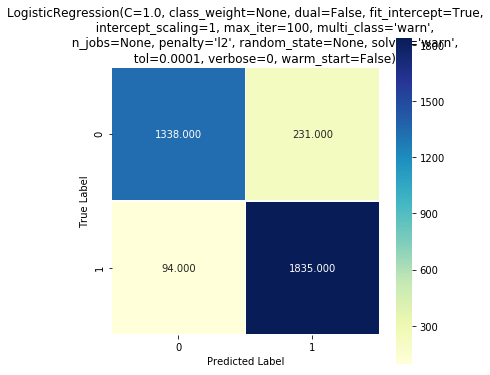

In [92]:
classify_users(bl_lr, X_train_scaled, X_test_scaled, y_train, y_test)

## EDA and Feature Engineering

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [45]:
missing_values = missing_values_table(enriched_df)
missing_values

Your selected dataframe has 17 columns.
There are 4 columns that have missing values.


,Missing Values,% of Total Values
external_url,12171,69.6
biography,4495,25.7
full_name,303,1.7
follows_to_followedby_ratio,6,0.0


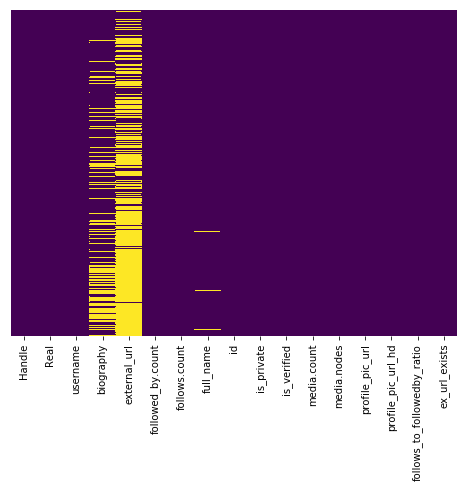

In [43]:
plt.figure(figsize=(8,6))
sns.heatmap(enriched_df.isnull(),yticklabels=False,cbar=False,cmap='viridis');

In [26]:
enriched_df['follows_to_followedby_ratio'] = enriched_df['follows.count']/enriched_df['followed_by.count']

In [39]:
enriched_df['ex_url_exists'] = [0 if type(x) == float else 1 for x in enriched_df['external_url']]

In [46]:
enriched_df['bio_exists'] = [0 if type(x) == float else 1 for x in enriched_df['biography']]

In [70]:
repeated_prof_pics = enriched_df['profile_pic_url'].value_counts().head(80).index.tolist()

In [71]:
enriched_df['prof_pic_duplicate'] = [1 if x in repeated_prof_pics else 0 for x in enriched_df['profile_pic_url']]

In [74]:
enriched_df[enriched_df['prof_pic_duplicate']==1]['Real'].value_counts()

0    405
1     24
Name: Real, dtype: int64

In [80]:
enriched_df.describe()

,Real,followed_by.count,follows.count,id,media.count,follows_to_followedby_ratio,ex_url_exists,bio_exists,prof_pic_duplicate
count,17488.000000,1.748800e+04,17488.000000,1.748800e+04,17488.000000,1.748200e+04,17488.000000,17488.000000,17488.000000
mean,0.549634,2.365129e+03,3358.146615,2.595493e+09,285.953625,inf,0.304037,0.742967,0.024531
std,0.497545,1.914366e+04,3129.167355,2.296924e+09,762.531915,NaN,0.460012,0.437010,0.154696
min,0.000000,0.000000e+00,0.000000,7.380000e+02,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000,2.370000e+02,551.750000,3.063246e+08,9.000000,7.758351e-01,0.000000,0.000000,0.000000
50%,1.000000,5.370000e+02,1464.000000,1.943691e+09,65.000000,1.948293e+00,0.000000,1.000000,0.000000
75%,1.000000,1.161000e+03,7452.000000,4.769349e+09,293.000000,1.378267e+01,1.000000,1.000000,0.000000
max,1.000000,1.628148e+06,7521.000000,6.944068e+09,43030.000000,inf,1.000000,1.000000,1.000000


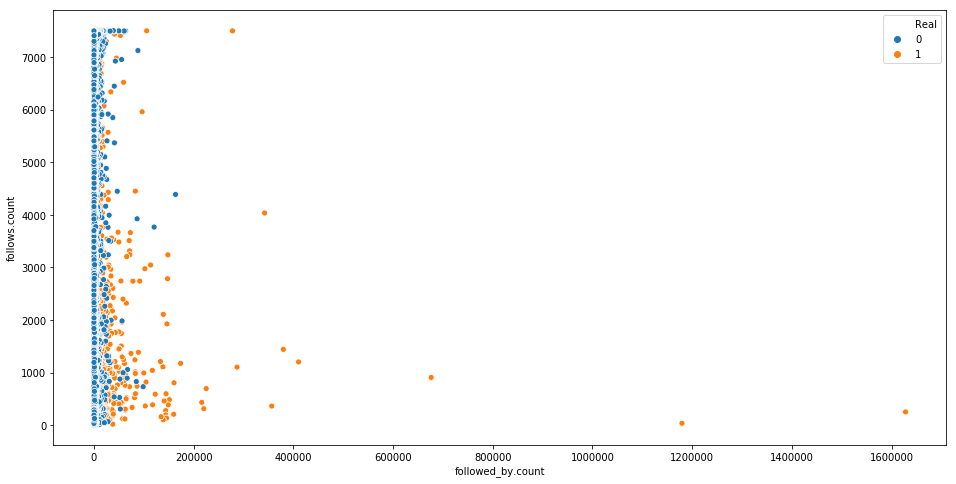

In [100]:
plt.figure(figsize=(6,12))
sns.scatterplot(x='followed_by.count',y='follows.count', data=enriched_df, hue='Real')

### Followed by Count

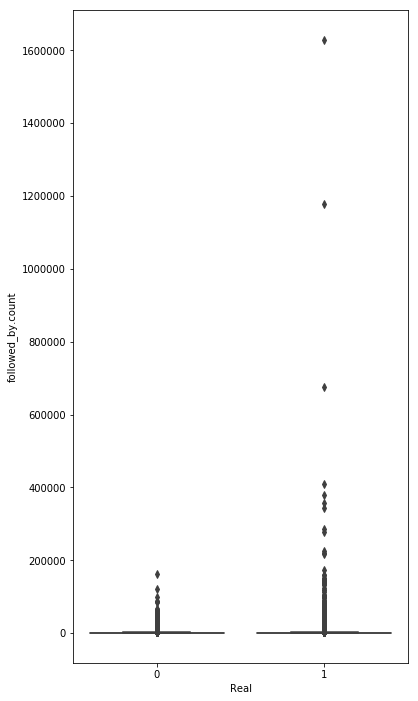

In [117]:
plt.figure(figsize=(6, 12))
sns.boxplot(x=enriched_df['Real'], y=enriched_df['followed_by.count'])

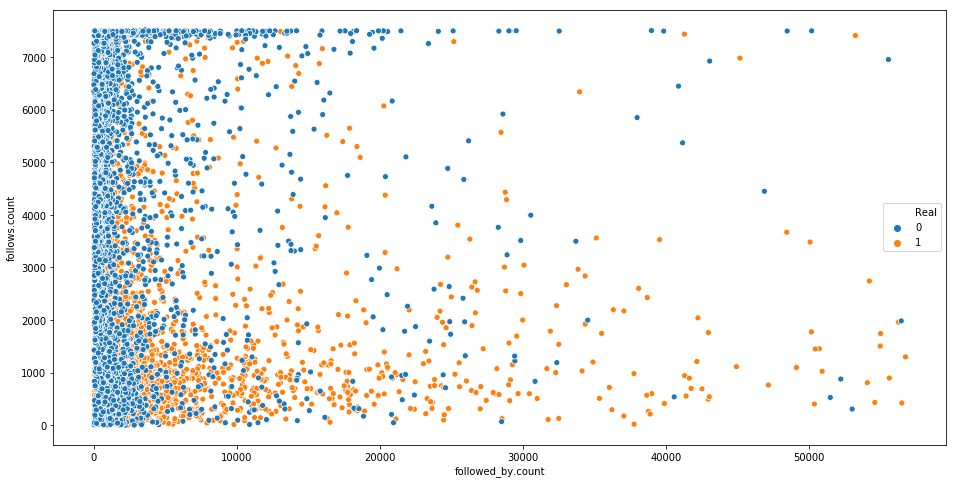

In [126]:
plt.figure(figsize=(16,8))
sns.scatterplot(x='followed_by.count',y='follows.count', data=enriched_df[enriched_df['followed_by.count']<np.std(enriched_df['followed_by.count'])*3], hue='Real');

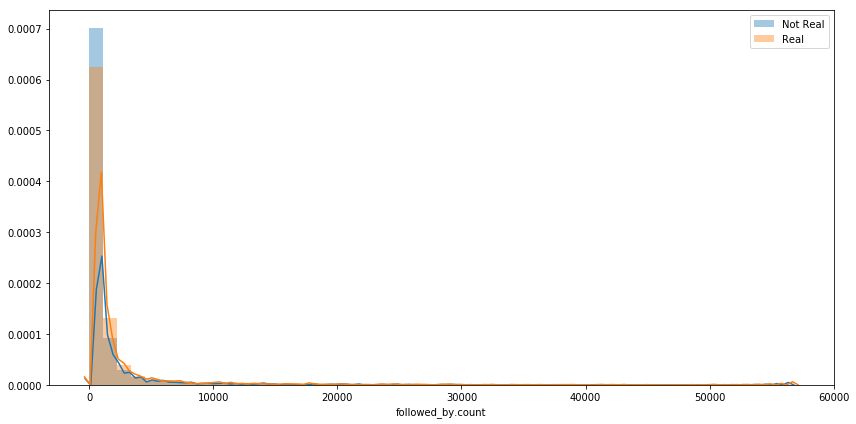

In [127]:
plt.figure(figsize = (12,6))
sns.distplot(enriched_df[(enriched_df['followed_by.count']<np.std(enriched_df['followed_by.count'])*3) & (enriched_df['Real']==0)]['followed_by.count'], label= 'Not Real')
sns.distplot(enriched_df[(enriched_df['followed_by.count']<np.std(enriched_df['followed_by.count'])*3) & (enriched_df['Real']==1)]['followed_by.count'], label= 'Real')
plt.legend()
plt.tight_layout()

In [131]:
fb_count_outliers = enriched_df[enriched_df['followed_by.count']>np.std(enriched_df['followed_by.count'])*3].index.tolist()
enriched_df.drop(fb_count_outliers, inplace=True)

In [161]:
enriched_df.groupby('Real').describe()['followed_by.count']

,count,mean,std,min,25%,50%,75%,max
Real,,,,,,,,
0,7852.0,1257.009806,3459.493405,0.0,163.0,371.0,949.25,56458.0
1,9209.0,1714.524596,4305.837321,0.0,330.0,642.0,1232.00,56500.0


### Follows Count

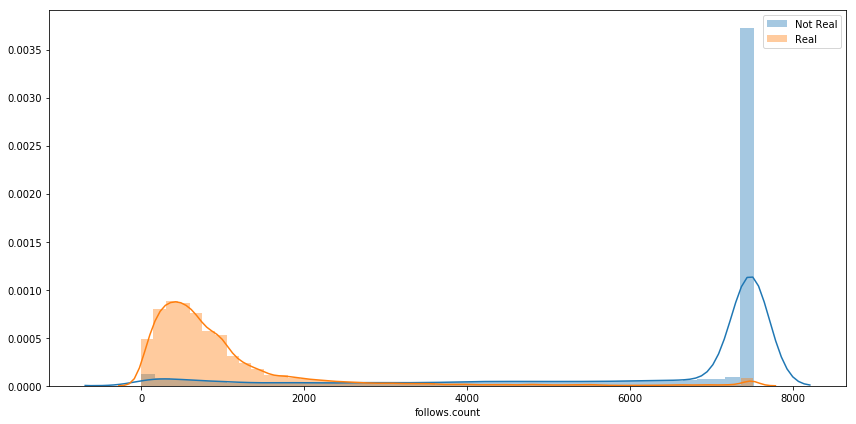

In [115]:
plt.figure(figsize = (12,6))
sns.distplot(enriched_df[(enriched_df['Real']==0)]['follows.count'], label= 'Not Real')
sns.distplot(enriched_df[(enriched_df['Real']==1)]['follows.count'], label= 'Real')
plt.legend()
plt.tight_layout()

In [23]:
enriched_df[enriched_df['follows.count']>7000]['Real'].value_counts()

0    5354
1     147
Name: Real, dtype: int64

In [160]:
enriched_df.groupby('Real').describe()['follows.count']

,count,mean,std,min,25%,50%,75%,max
Real,,,,,,,,
0,7852.0,6199.613474,2254.234805,0.0,5789.25,7477.0,7496.0,7521.0
1,9209.0,991.810729,1229.397920,0.0,357.00,639.0,1057.0,7511.0


### Media Count

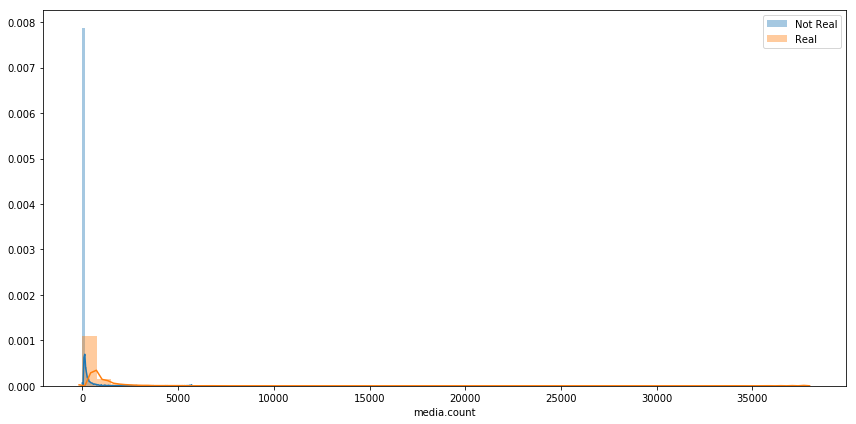

In [136]:
plt.figure(figsize = (12,6))
sns.distplot(enriched_df[(enriched_df['Real']==0)]['media.count'], label= 'Not Real')
sns.distplot(enriched_df[(enriched_df['Real']==1)]['media.count'], label= 'Real')
plt.legend()
plt.tight_layout()

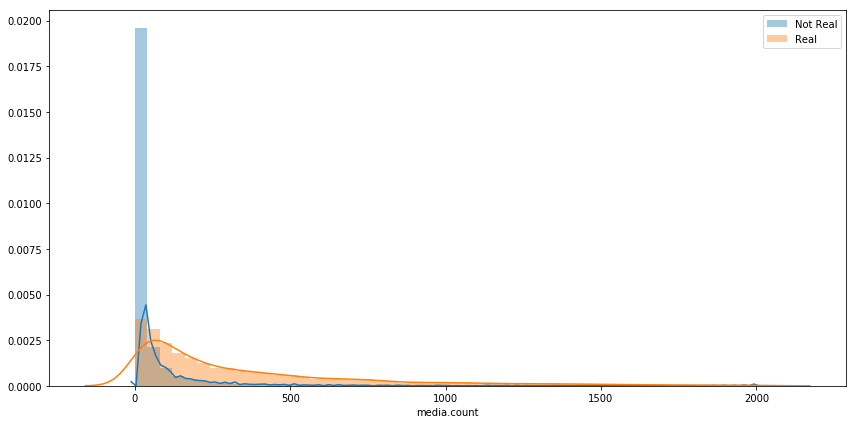

In [137]:
plt.figure(figsize = (12,6))
sns.distplot(enriched_df[(enriched_df['Real']==0) & (enriched_df['media.count']< np.std(enriched_df['media.count'])*3)]['media.count'], label= 'Not Real')
sns.distplot(enriched_df[(enriched_df['Real']==1) & (enriched_df['media.count']< np.std(enriched_df['media.count'])*3)]['media.count'], label= 'Real')
plt.legend()
plt.tight_layout()

In [138]:
enriched_df[enriched_df['media.count']>np.std(enriched_df['media.count'])*3]['Real'].value_counts()

1    328
0     12
Name: Real, dtype: int64

In [139]:
media_count_outliers = enriched_df[enriched_df['media.count']>np.std(enriched_df['media.count'])*3].index.tolist()
enriched_df.drop(media_count_outliers, inplace=True)

In [162]:
enriched_df.groupby('Real').describe()['media.count']

,count,mean,std,min,25%,50%,75%,max
Real,,,,,,,,
0,7852.0,48.031584,135.764474,0.0,1.0,8.0,31.0,1996.0
1,9209.0,354.306765,397.759948,0.0,72.0,201.0,491.0,2013.0


### Is Private

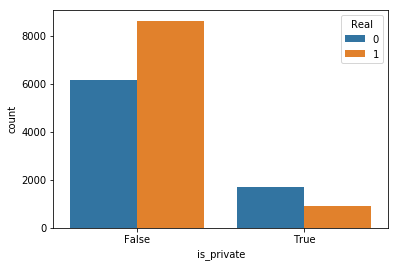

In [134]:
sns.countplot(x=enriched_df['is_private'], hue=enriched_df['Real'])

### Is Verified

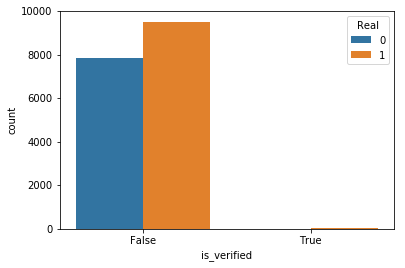

In [135]:
sns.countplot(x=enriched_df['is_verified'], hue=enriched_df['Real'])

### External URL Exists

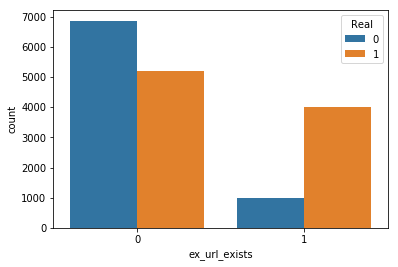

In [155]:
sns.countplot(x=enriched_df['ex_url_exists'], hue=enriched_df['Real'])

### Bio Exists

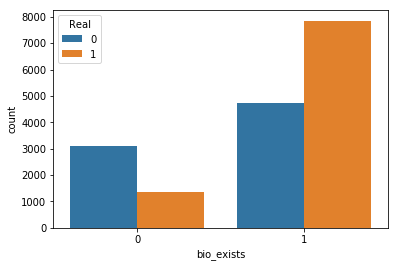

In [156]:
sns.countplot(x=enriched_df['bio_exists'], hue=enriched_df['Real'])

## More Feature Engineering

In [187]:
modeling_df = enriched_df[['Real','followed_by.count','follows.count','is_private','media.count','follows_to_followedby_ratio','ex_url_exists','bio_exists','prof_pic_duplicate']].copy()

In [188]:
modeling_df.reset_index(drop=True, inplace=True)

In [189]:
features = modeling_df.drop(['Real', 'follows_to_followedby_ratio'], axis=1).copy()

In [190]:
poly = PolynomialFeatures(interaction_only=True,include_bias=False)
features = pd.DataFrame(poly.fit_transform(features), columns=poly.get_feature_names(input_features=features.columns))

In [191]:
features.head()

,followed_by.count,follows.count,is_private,media.count,ex_url_exists,bio_exists,prof_pic_duplicate,followed_by.count follows.count,followed_by.count is_private,followed_by.count media.count,...,is_private media.count,is_private ex_url_exists,is_private bio_exists,is_private prof_pic_duplicate,media.count ex_url_exists,media.count bio_exists,media.count prof_pic_duplicate,ex_url_exists bio_exists,ex_url_exists prof_pic_duplicate,bio_exists prof_pic_duplicate
0,801.0,140.0,0.0,402.0,1.0,1.0,0.0,112140.0,0.0,322002.0,...,0.0,0.0,0.0,0.0,402.0,402.0,0.0,1.0,0.0,0.0
1,56500.0,421.0,0.0,472.0,1.0,1.0,0.0,23786500.0,0.0,26668000.0,...,0.0,0.0,0.0,0.0,472.0,472.0,0.0,1.0,0.0,0.0
2,53250.0,7412.0,0.0,1145.0,1.0,1.0,0.0,394689000.0,0.0,60971250.0,...,0.0,0.0,0.0,0.0,1145.0,1145.0,0.0,1.0,0.0,0.0
3,54611.0,431.0,0.0,750.0,1.0,1.0,0.0,23537341.0,0.0,40958250.0,...,0.0,0.0,0.0,0.0,750.0,750.0,0.0,1.0,0.0,0.0
4,50928.0,1024.0,0.0,906.0,0.0,1.0,0.0,52150272.0,0.0,46140768.0,...,0.0,0.0,0.0,0.0,0.0,906.0,0.0,0.0,0.0,0.0


In [192]:
poly_model = pd.concat([modeling_df[['Real','follows_to_followedby_ratio']], features], axis=1)

In [193]:
poly_model.columns

Index(['Real', 'follows_to_followedby_ratio', 'followed_by.count',
       'follows.count', 'is_private', 'media.count', 'ex_url_exists',
       'bio_exists', 'prof_pic_duplicate', 'followed_by.count follows.count',
       'followed_by.count is_private', 'followed_by.count media.count',
       'followed_by.count ex_url_exists', 'followed_by.count bio_exists',
       'followed_by.count prof_pic_duplicate', 'follows.count is_private',
       'follows.count media.count', 'follows.count ex_url_exists',
       'follows.count bio_exists', 'follows.count prof_pic_duplicate',
       'is_private media.count', 'is_private ex_url_exists',
       'is_private bio_exists', 'is_private prof_pic_duplicate',
       'media.count ex_url_exists', 'media.count bio_exists',
       'media.count prof_pic_duplicate', 'ex_url_exists bio_exists',
       'ex_url_exists prof_pic_duplicate', 'bio_exists prof_pic_duplicate'],
      dtype='object')

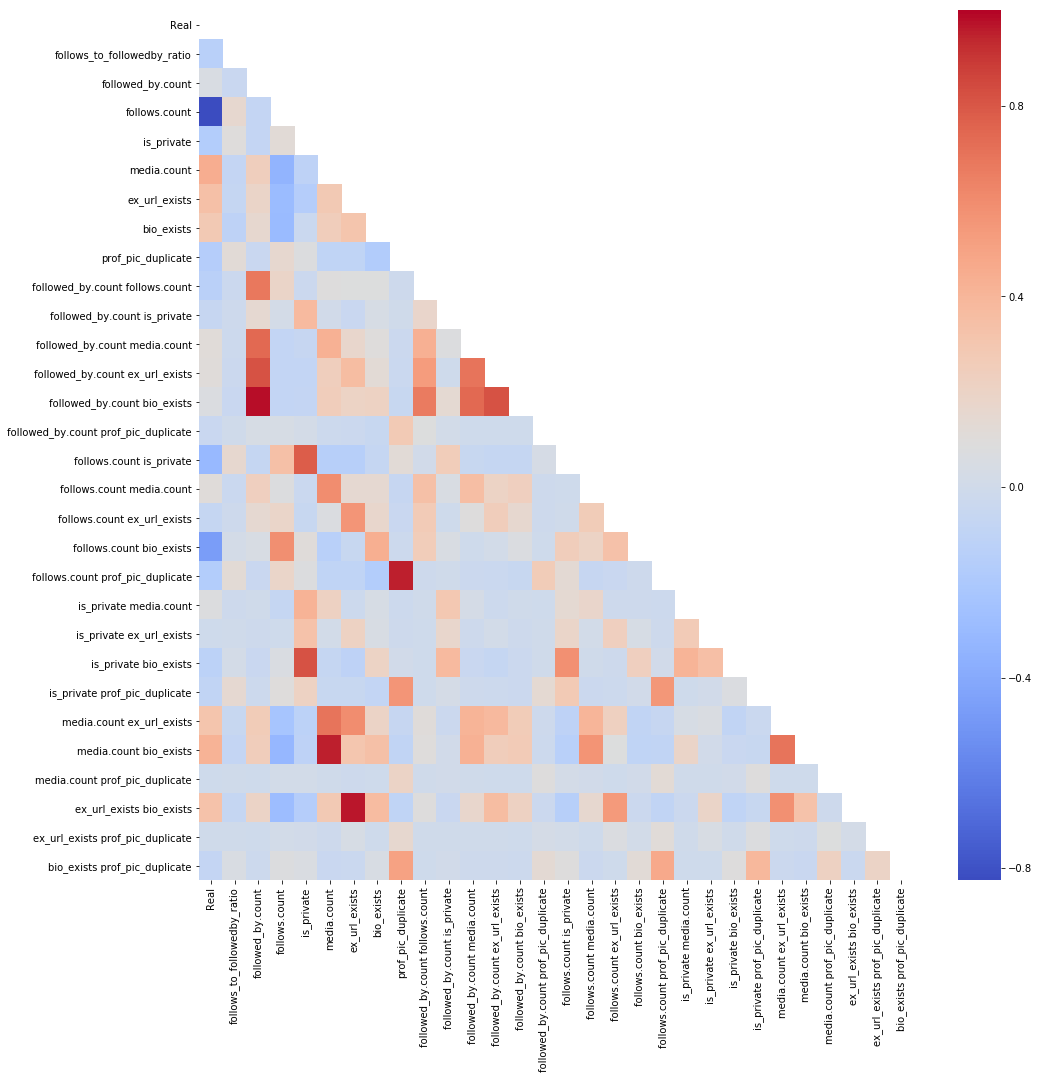

In [195]:
plt.figure(figsize=(16,16))
mask = np.zeros_like(poly_model.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(poly_model.corr(),mask=mask,cmap=plt.cm.coolwarm,annot=False)

In [196]:
poly_model.to_csv('poly_model.csv')